In [1]:
import pandas as pd

In [36]:
dataset = {"text":[], "label": []}

In [37]:
with open("./data/sarcasm/val_en.txt","r", encoding="utf-8") as f:
    text = f.read()
    # parts = line.split(" ")
    # print(parts[1])
    lines = text.split("\n")
    for line in lines:
        parts = line.split("	")
        if len(parts) < 2:
            continue
        
        dataset["text"].append(parts[0])
        dataset["label"].append(parts[1])

print(dataset)

{'text': ['Sentence', 'I love it when professors draw a big question mark next to my answer on an exam because I’m always like yeah I don’t either ¯\\_(ツ)_/¯', '"@jimrossignol I choose to interpret it as ""XD"": the universal emoticon for laughing at those poor, poor folks in Ubisoft\'s marketing department who have to deal with that branding until the servers quietly shut down 8 months after launch."', 'Loving season 4 of trump does America. Funniest season yet #DonaldTrump #Trump #MAGA #MAGA2020', "@heathoween @tylerrjoseph Yes, because we need literally every single fucking celebrity to speak up on a topic that's been forced down everyone's throats for the past four months. I use the internet to get away from these fucking real life problems; not everyone needs to weigh in.", "Not at all concerning that a man's just been round to fiddle with the boiler and now he's left the carbon monoxide alarm won't stop beeping", 'It’s been a blissful 2.5 hours of sleep tonight', 'Falling asleep 

In [38]:
df = pd.DataFrame(dataset)

In [39]:
df_1 = df.iloc[1:]
df_1.columns = ["Text", "Label"]
df_1

,Text,Label
1,I love it when professors draw a big question ...,sarcastic
2,"""@jimrossignol I choose to interpret it as """"X...",sarcastic
3,Loving season 4 of trump does America. Funnies...,sarcastic
4,"@heathoween @tylerrjoseph Yes, because we need...",sarcastic
5,Not at all concerning that a man's just been r...,sarcastic
...,...,...
344,"Oh no, I have to listen to a cement mixer all ...",non-sarcastic
345,My family has asked me to make a Mother's Day ...,non-sarcastic
346,"Claires, you should not do full hysterectomies.",non-sarcastic
347,A lot of people don't have a wife.,non-sarcastic


In [40]:
df_1.to_csv("./val.csv")

In [41]:
train = pd.read_csv("./train.csv")
val = pd.read_csv("./val.csv")
new_train = pd.concat([train, val], axis=0)

In [42]:
new_train.to_csv("train_1.csv")

In [45]:
new_train = new_train.drop(columns="Unnamed: 0")

In [53]:
new_train.to_csv("train_1.csv",index=False)


In [50]:
new_train

,Text,Label
0,The only thing I got from college is a caffein...,sarcastic
1,Remember the hundred emails from companies whe...,sarcastic
2,Today my pop-pop told me I was not “forced” to...,sarcastic
3,@VolphanCarol @littlewhitty @mysticalmanatee I...,sarcastic
4,Why would Alexa's recipe for Yorkshire pudding...,sarcastic
...,...,...
343,"Oh no, I have to listen to a cement mixer all ...",non-sarcastic
344,My family has asked me to make a Mother's Day ...,non-sarcastic
345,"Claires, you should not do full hysterectomies.",non-sarcastic
346,A lot of people don't have a wife.,non-sarcastic


In [55]:
pd.read_csv("./test.csv").drop(columns="Unnamed: 0").to_csv("test_1.csv", index=False)

# Models

In [56]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

<Axes: ylabel='Frequency'>

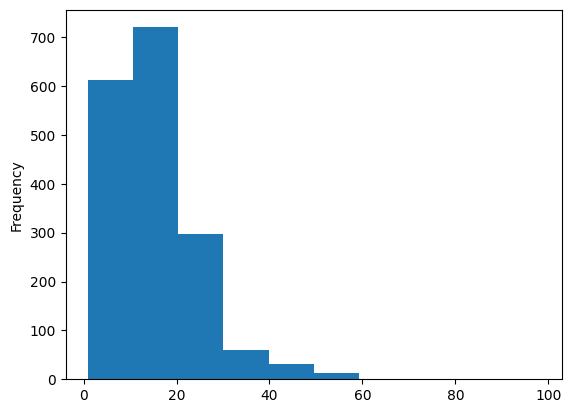

In [70]:
train["Text"].str.split().apply(len).plot.hist()

<Axes: >

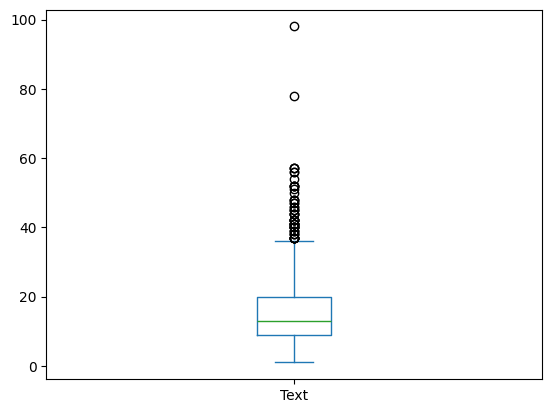

In [66]:
train["Text"].str.split().apply(len).plot.box()

<Axes: ylabel='Frequency'>

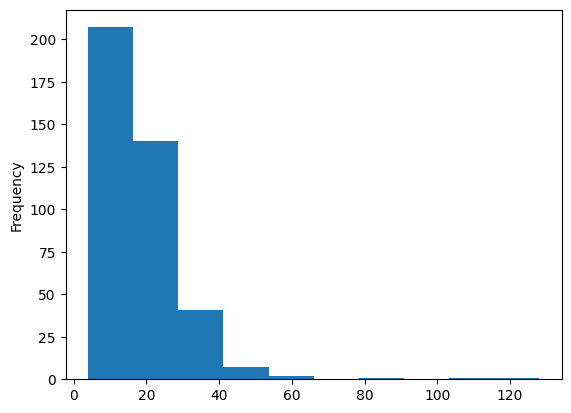

In [71]:
test["Text"].str.split().apply(len).plot.hist()

<Axes: >

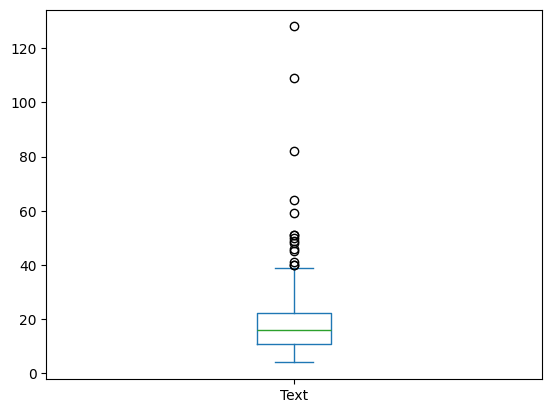

In [72]:
test["Text"].str.split().apply(len).plot.box()

In [81]:
outliers_limit = 37

In [82]:
train_1 = train[train["Text"].str.split().apply(len) < outliers_limit].copy()
test_1 = test[test["Text"].str.split().apply(len) < outliers_limit].copy()

<Axes: >

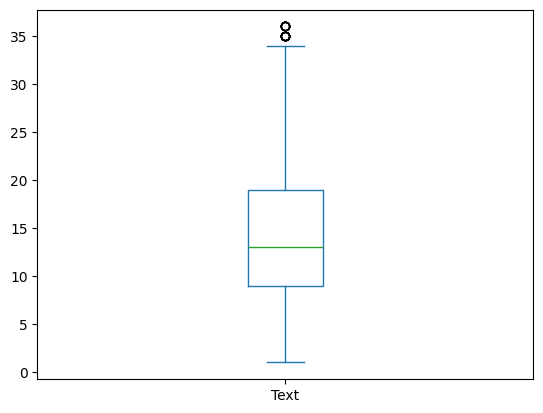

In [83]:
train_1["Text"].str.split().apply(len).plot.box()

<Axes: >

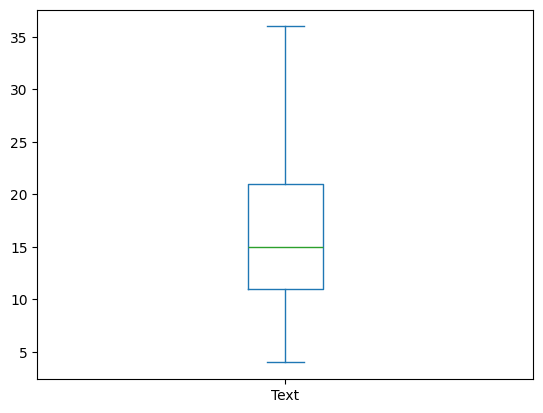

In [84]:
test_1["Text"].str.split().apply(len).plot.box()

<Axes: ylabel='Frequency'>

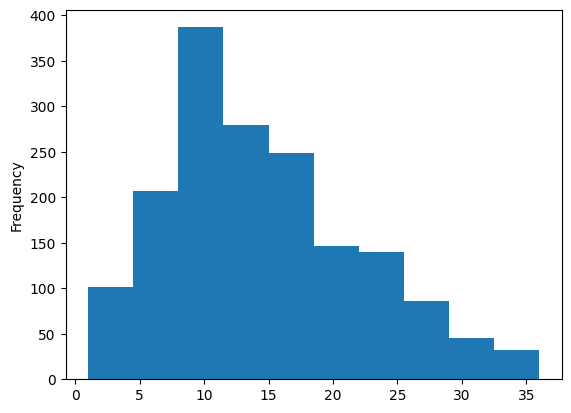

In [86]:
train_1["Text"].str.split().apply(len).plot.hist()

<Axes: ylabel='Frequency'>

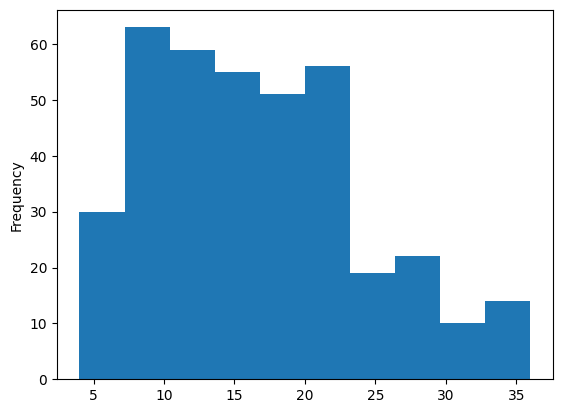

In [87]:
test_1["Text"].str.split().apply(len).plot.hist()

In [88]:
def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = set()
    for text in texts:
        for word in text.split(" "):
            vocabulary.add(word)
    return list(vocabulary)

In [89]:
vocabulary = get_vocabulary(train_1["Text"].tolist())

In [90]:
vocabulary_len = len(vocabulary)
vocabulary_len

6551

In [91]:
max_vocabulary_size = 6000

In [93]:
x_train, y_train = train_1["Text"], pd.get_dummies(train_1["Label"])
x_test, y_test = test_1["Text"], pd.get_dummies(test_1["Label"])

In [94]:
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence

In [95]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(x_train.values)

In [96]:
x_train_embedings = tokenizer.texts_to_sequences(x_train)
x_test_embedings = tokenizer.texts_to_sequences(x_test)

In [99]:
from matplotlib import pyplot as plt

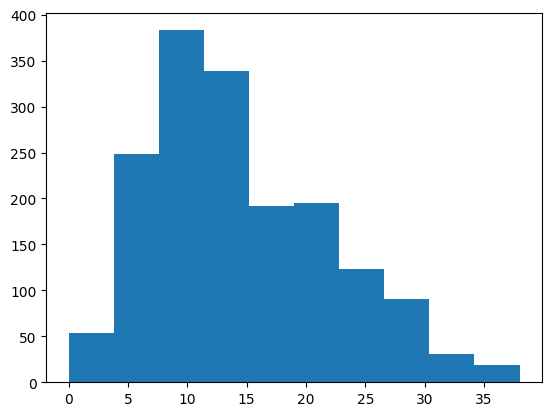

In [100]:
plt.hist([len(tokens) for tokens in x_train_embedings]);

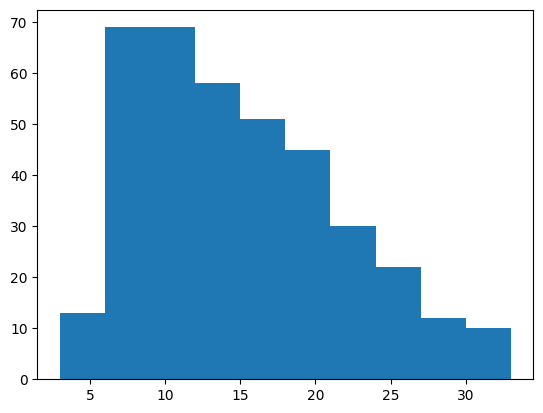

In [101]:
plt.hist([len(tokens) for tokens in x_test_embedings]);

In [119]:
num_classes = len(df_1["Label"].unique())
output_neurons = 1 if num_classes == 2 else num_classes

In [102]:
max_word_len = 30

In [103]:
x_train_embedings_padded = sequence.pad_sequences(x_train_embedings, maxlen=max_word_len)
x_test_embedings_padded = sequence.pad_sequences(x_test_embedings, maxlen=max_word_len)

In [144]:
from keras.api.models import Sequential
from keras.api.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM
import keras
from sklearn.metrics import confusion_matrix, classification_report

In [137]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=128),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(num_classes, activation="softmax")
])

In [138]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [139]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.Recall(), keras.metrics.F1Score(), keras.metrics.Precision()]
)

In [140]:
history = model.fit(x_train_embedings_padded, y_train, validation_split=0.2, batch_size=16, epochs=4)

Epoch 1/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - f1_score: 0.4609 - loss: 0.6904 - precision_3: 0.5355 - recall_3: 0.5355 - val_f1_score: 0.5512 - val_loss: 0.6709 - val_precision_3: 0.6209 - val_recall_3: 0.6209
Epoch 2/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - f1_score: 0.6834 - loss: 0.6032 - precision_3: 0.7035 - recall_3: 0.7035 - val_f1_score: 0.6927 - val_loss: 0.5814 - val_precision_3: 0.6985 - val_recall_3: 0.6985
Epoch 3/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - f1_score: 0.8914 - loss: 0.2903 - precision_3: 0.8928 - recall_3: 0.8928 - val_f1_score: 0.6769 - val_loss: 0.6770 - val_precision_3: 0.6806 - val_recall_3: 0.6806
Epoch 4/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - f1_score: 0.9636 - loss: 0.1268 - precision_3: 0.9636 - recall_3: 0.9636 - val_f1_score: 0.6927 - val_loss: 0.7946 - val_precision_3: 0.6985 - val_recall_3: 0.6985


In [111]:
import seaborn as sns

<Axes: >

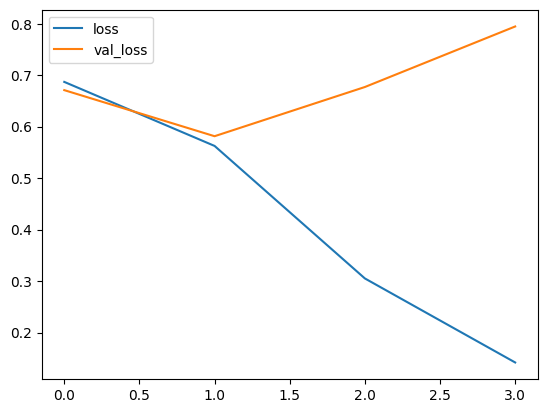

In [141]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [148]:
predicts = model.predict(x_test_embedings_padded)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [154]:
test_y_arg = y_test.values.argmax(axis=1)
predicts_arg = predicts.argmax(axis=1)

In [145]:
print(classification_report(test_y_arg, predicts_arg))

              precision    recall  f1-score   support

           0       0.59      0.76      0.66       189
           1       0.66      0.47      0.55       190

    accuracy                           0.61       379
   macro avg       0.63      0.62      0.61       379
weighted avg       0.63      0.61      0.61       379



Text(0.5, 1.0, 'Confusion Matrix')

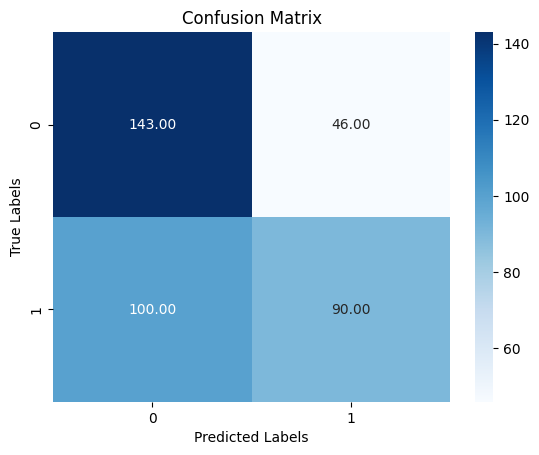

In [146]:
sns.heatmap(confusion_matrix(test_y_arg, predicts_arg), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")